# Sometimes there's erroneous data that causes the simple spatiotemporal track splitting algorithm (shown [here](https://github.com/derekeden/trackio/blob/main/notebooks/04%20-%20Grouping%20Points%20and%20Splitting%20Tracks.ipynb)) to fail and produce unrealistic tracks. 

# In this case, you might want to explore isolating this data and splitting it another way. 
___

In [1]:

import trackio as tio
import pandas as pd

___
## Let's define a dataset with some files containing bad data.

In [2]:
#define the data_path
data_path = 'example0_bad_data'

#define the files
files = ['files/bad_data.csv']

#read the processed Dataset
ds = tio.read(raw_files=files,
              data_path=data_path)

ds


No dataset.db found in c:\code\trackio\notebooks\example0_bad_data. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    1 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    0 Split Agent Files
Static Data Fields:
    []
Dynamic Data Fields:
    ['X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example0_bad_data

___
## Now let's split them using the basic spatiotemporal splitting method:

In [3]:
#group the points
ds = ds.group_points(groupby='MMSI',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['MMSI'],
                     prefix='Vessel_',
                     ncores=4)
#split the tracks
ds = ds.split_tracks_spatiotemporal(time=3600*12,
                                    distance=0.75)
#refresh the meta
ds.refresh_meta()

Grouping points: 100%|██████████| 1/1 [00:00<00:00, 399.99it/s]


Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 27.77it/s]

New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data


Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    1 Split Agent Files
Static Data Fields:
    ['Agent ID', 'MMSI']
Dynamic Data Fields:
    ['Time', 'X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example0_bad_data

___
## Let's look for an agent with an abnormal amount of tracks.

In [4]:
#agent id with max number of tracks
agents = ds.agents.iloc[[ds.agents['ntracks'].argmax()]]
agent_ids = agents.index

agents

,MMSI,npoints,ntracks,Xmin,Xmax,Ymin,Ymax,Start Time,End Time,File,geometry
Agent ID,,,,,,,,,,,
Vessel_1,1,57,17,-74.266533,-73.691153,39.427896,40.721166,1970-01-01,1970-01-01 00:00:01,c:\code\trackio\notebooks\example0_bad_data\Ve...,"POLYGON ((-73.69115 39.42790, -73.69115 40.721..."


___
# If we plot the agent's data, we can clearly see these are three tracks from separate entities that have accidentally use the same unique identifier at the same time

Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 105.31it/s]


<Axes: >

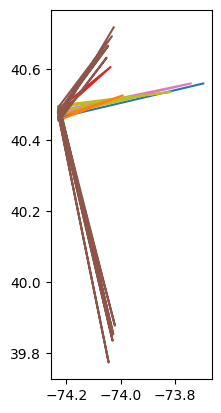

In [5]:
#convert to GeoDataFrame and plot
ds.to_gdf().plot(column='Track ID')

Converting tracks to DataFrame: 100%|██████████| 1/1 [00:00<00:00, 59.80it/s]


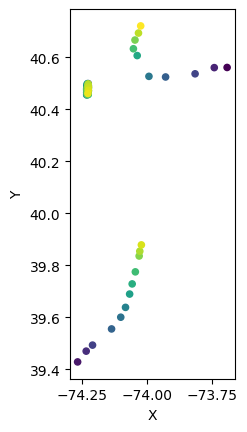

In [6]:
#convert to dataframe and plot
df = ds.to_df(agents=agent_ids)
df.plot.scatter(x='X', y='Y', c='Time').set_aspect('equal')

___
## Instead, we can first try a modified spatiotemporal approach that can account for this issue.

This method works using the same spatiotemporal thresholds as the more simple method. However, the algorithm is implemented slightly differently.

Here, an initial single track is assumed for the agent, starting with the first point. Then, iteration is performed over points. If the second point falls within the spatiotemporal thresholds of the first point, it is connected to the first track. Otherwise, a second track is created starting with the second point. For the third point, the algorithm checks to see if it falls within the thresholds of any existing tracks and appends it, if not creates a new track. This process is repeated until the last point belonging to the agent.

In [7]:
#split tracks overlapping in time using a modified spatiotemporal threshold
ds = ds.split_overlapping_tracks_spatiotemporal(agents=agent_ids,
                                                time=3600*12,
                                                distance=0.2)

#refresh meta
ds = ds.refresh_meta()

ds.agents

Splitting overlapping tracks using spatiotemporal threshold: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]
Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]

New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data


,MMSI,npoints,ntracks,Xmin,Xmax,Ymin,Ymax,Start Time,End Time,File,geometry
Agent ID,,,,,,,,,,,
Vessel_1,1,57,3,-74.266533,-73.691153,39.427896,40.721166,1970-01-01,1970-01-01 00:00:01,c:\code\trackio\notebooks\example0_bad_data\Ve...,"POLYGON ((-73.69115 39.42790, -73.69115 40.721..."


___
## Notice there are only three tracks now.

Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 111.11it/s]


<Axes: >

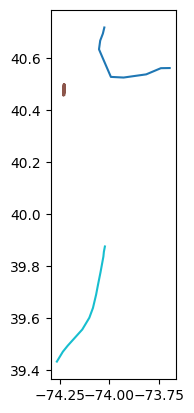

In [8]:
#convert to GeoDataFrame and plot
ds.to_gdf().plot(column='Track ID')

___
## Still, spatiotemporal splitting might not be able to separate two closeby tracks. In this case, we can try different clustering algorithms.

## First, try K-Means first, since we know the number of target clusters.

This is a wrapper over the `sklearn.cluster.KMeans` class, and accepts all keyword arguments that the `sklearn` class accepts, see documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

Using KMeans clustering to split tracks: 100%|██████████| 1/1 [00:00<00:00, 285.72it/s]


Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 62.51it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 117.54it/s]


<Axes: >

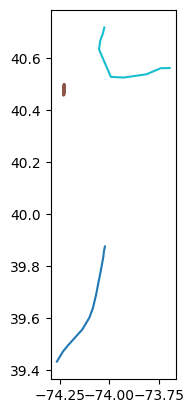

In [9]:
#split tracks using kmeans - simply use X,Y coordinates as features
ds = ds.split_tracks_kmeans(agents=agent_ids,
                            n_clusters=3,
                            feature_cols=['X','Y'],
                            algorithm='elkan') #the "llyod" algorithm actually fails in this example and should be chosen with care

#refresh meta
ds = ds.refresh_meta()

#convert to GeoDataFrame and plot
ds.to_gdf().plot(column='Track ID')

___
## This is a relatively simple example. In some cases this still might not work, or the number of clusters may not be easily identifiable. In which case, there is a DBSCAN based track splitting algorithm.

Using DBSCAN clustering to split tracks: 100%|██████████| 1/1 [00:00<00:00, 399.99it/s]


Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s]


<Axes: >

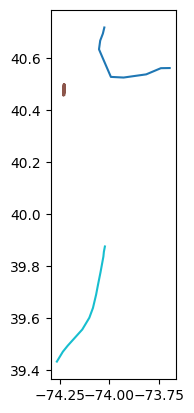

In [10]:
#split tracks using dbscan - the eps and min_samples may take time to get right for your use case
ds = ds.split_tracks_dbscan(agents=agent_ids,
                            feature_cols=['X','Y'],
                            eps=1,
                            min_samples=1)

#refresh meta
ds = ds.refresh_meta()

#convert to GeoDataFrame and plot
ds.to_gdf().plot(column='Track ID')

___
## In some cases, there might be erroneous data points mixed in with good data. This bad data may have slipped through previous pre-processing and QC checks.

## An example would be intermittent spurious coordinates in AIS data along an otherwise good looking track.


No dataset.db found in c:\code\trackio\notebooks\example0_bad_data1. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



Grouping points: 100%|██████████| 1/1 [00:00<00:00, 399.88it/s]


Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 32.79it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data1


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 95.24it/s]


<Axes: >

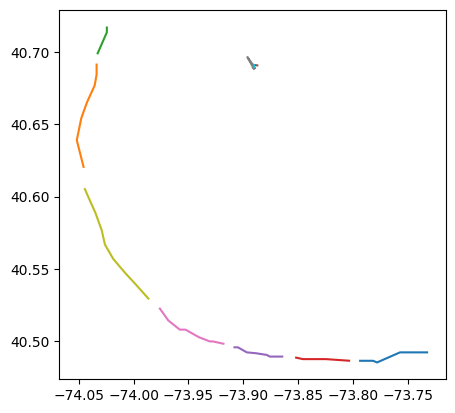

In [11]:
#define the data_path
data_path = 'example0_bad_data1'

#define the files
files = ['files/bad_data1.csv']

#read the processed Dataset
ds = tio.read(raw_files=files,
              data_path=data_path)

#split the points
ds = ds.group_points(groupby='MMSI',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['MMSI'],
                     prefix='Vessel_',
                     ncores=4)

#split tracks using basic thresholds
ds = ds.split_tracks_spatiotemporal(time=3600*12,
                                    distance=0.1)

#refresh meta
ds = ds.refresh_meta()

#plot
ds.to_gdf().plot(column='Track ID')


___
## In this case, where there is obviously erroneous data, you can try "repairing" the spatiotemporal splits.

In this type of case, the continuous "good" data will be split into separate tracks at the location of the "bad" data. This algorithm simply looks at all the possible pairs of tracks in the agent and checks if they can be rejoined based on the threshold, and then will chain together all tracks that have overlapping start/end points.

Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data1


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 68.55it/s]


<Axes: >

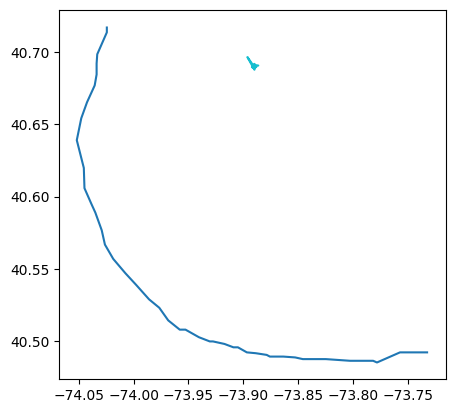

In [12]:
#repair the spatiotemporal splits
ds = ds.repair_tracks_spatiotemporal(time=3600*12,
                                     distance=0.1)

#refresh meta
ds = ds.refresh_meta()

#plot
ds.to_gdf().plot(column='Track ID')

___
## If one approach doesn't work, try one of the other splitting algorithms. Still if no luck, try to remove this data as part of pre-processing (e.g. clip data overland out of the raw data).

Using DBSCAN clustering to split tracks: 100%|██████████| 1/1 [00:00<00:00, 400.11it/s]


Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data1


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 124.90it/s]


<Axes: >

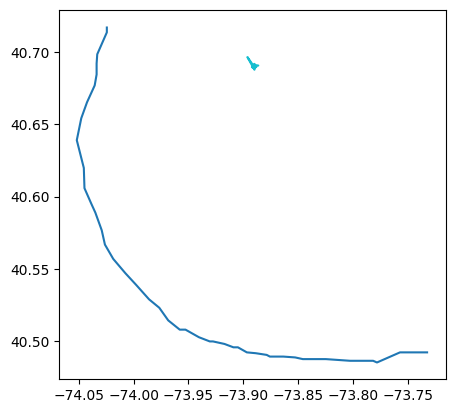

In [13]:
#split using DBSCAN
ds = ds.split_tracks_dbscan(eps=0.5,
                            min_samples=1)

#refresh meta
ds = ds.refresh_meta()

#convert to GeoDataFrame and plot
ds.to_gdf().plot(column='Track ID')

___
## The last way to split tracks is to split based on dynamic data fields along the track itself. 

## Amongst other use cases, this is useful if you already have a unique identifier for each track and are just trying to get the tracks into the `trackio` framework.

<Axes: xlabel='X', ylabel='Y'>

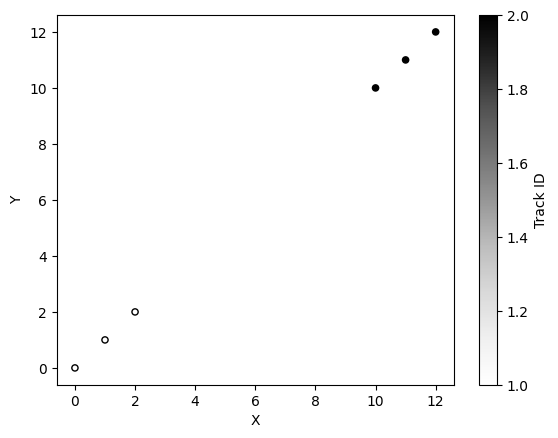

In [14]:
#make some fake data
df1 = pd.DataFrame({'X':[0,1,2], 'Y':[0,1,2]})
df1['Track ID'] = 1
df2 = df1.copy() + 10
df2['Track ID'] = 2
df = pd.concat([df1,df2]).reset_index(drop=True)
df['Agent ID'] = 1
df['Time'] = pd.date_range(pd.to_datetime('now'), freq='1H', periods=len(df))

df.plot.scatter(x='X',y='Y',c='Track ID', edgecolor='k')

In [15]:
df

,X,Y,Track ID,Agent ID,Time
0,0,0,1,1,2024-03-15 16:28:15.519511
1,1,1,1,1,2024-03-15 17:28:15.519511
2,2,2,1,1,2024-03-15 18:28:15.519511
3,10,10,2,1,2024-03-15 19:28:15.519511
4,11,11,2,1,2024-03-15 20:28:15.519511
5,12,12,2,1,2024-03-15 21:28:15.519511


In [16]:
#create a dataset, split points
ds = tio.from_df(df,
                 data_path='./example_split_by_data')

#split the points
ds = ds.group_points(groupby='Agent ID',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['Agent ID'],
                     data_cols=['X','Y','Time','Track ID'],
                     prefix='Agent_',
                     ncores=1)



No dataset.db found in c:\code\trackio\notebooks\example_split_by_data. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



Grouping points: 100%|██████████| 1/1 [00:00<00:00, 153.84it/s]


## Now let's split by the `Track ID` dynamic data column. The algorithm will split the data whenever there is a change in the value of this column.

Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 74.08it/s]


New meta/databases saved to c:\code\trackio\notebooks\example_split_by_data


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 105.33it/s]


<Axes: >

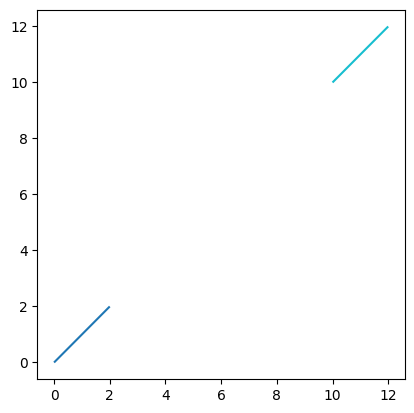

In [17]:
#split by data by dynamic data column
ds = ds.split_tracks_by_data(data_col='Track ID')

#refresh meta
ds = ds.refresh_meta()

#convert to geodataframe and plot
ds.to_gdf().plot(column='Track ID')

___
## You can also use this for splitting tracks into sub-tracks based on particular dynamic data fields, such as splitting out portions of tracks within polygons, or splitting tracks at some major event (e.g. a stop).

## See [11 - Analysis.ipynb](https://github.com/derekeden/trackio/blob/main/notebooks/11%20-%20Analysis.ipynb) for an example of this.
___